## 1. Load the packages

In [1]:
# Data processing packages
import numpy as np
import pandas as pd
from collections import Counter

# Machine learning packages
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectPercentile, chi2, mutual_info_regression, SelectFromModel
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.manifold import TSNE

import torch

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# Others
import time
from pathlib import Path

## 2. Read the data

In [ ]:
X1 = pd.read_csv("X1.csv")
Y1 = pd.read_csv("Y1.csv", header=None, names=['revenue '])
X2 = pd.read_csv("X2.csv")

In [ ]:
X1

## 3. Data Preprocessing

### STEP 1: Data Cleaning (columns drop off and missing value processing)

In [ ]:
def data_cleaning_process(df):
    """
    This function will drop columns, like "Unnamed: 0", "title", "img_url", "description" from the dataset, and replace the missing value in `runtime` column with a median value, and replace the missing value in `genres` with "Others".
    :param df: A dataframe (X1 or X2)
    :return: A new cleaned dataframe
    """

    new_df = df.copy()
    # missing value for runtime: replace "\\N" with median value
    median_runtime = np.median(new_df.loc[new_df['runtime'] != '\\N', 'runtime'].astype(np.int64))
    new_df['runtime'] = np.where(new_df['runtime'] == '\\N', median_runtime, new_df['runtime']).astype(np.int64)

    # missing value for genres: replace "\\N" with "Others"
    new_df.loc[new_df['genres'] == "\\N", "genres"] = "Others"

    # drop "Unnamed: 0", "title", "img_url", "description"
    new_df = new_df.drop(["Unnamed: 0", "title", "img_url", "description"], axis=1)

    return new_df

In [ ]:
X1_cleaned = data_cleaning_process(X1)

### STEP 2: Data Type Split (Numerical, Categorical, Embeddings)

In [ ]:
def data_type_split(df):
    """
    This function will split the whole dataset into different sub dataset according to the data types of the columns
    :param df: A dataframe
    :return: three datadrames, which are numerical, categorical, embeddings
    """

    new_df = df.copy()
    numeric_features = new_df.select_dtypes(include="number").columns.tolist()
    non_numeric_features = new_df.select_dtypes(exclude="number").columns.tolist()
    embedding_features = ['img_embeddings', 'text_embeddings']
    numeric_features.remove('is_adult')
    categorical_features = non_numeric_features.copy()
    [categorical_features.remove(col) for col in embedding_features]
    categorical_features.append('is_adult')
    return new_df.loc[:, numeric_features], new_df.loc[:, categorical_features], new_df.loc[:, embedding_features]

In [ ]:
df_num, df_cat, df_emb = data_type_split(X1_cleaned)

In [ ]:
df_num.head()

In [ ]:
df_cat.head()

In [ ]:
df_emb.head()

### STEP 3: Categorical Columns Processing (Genres --> multilable binary type, Studio --> studio_frequency)

In [ ]:
dict_cat_freq = torch.load("studio_freq")

In [ ]:
mlb = MultiLabelBinarizer()
df_cat['genres_split'] = df_cat['genres'].apply(lambda x: x.split(","))
mlb.fit(df_cat['genres_split'])

In [ ]:
def categorical_process(df):
    """
    This function will process on `genres` and `studio` columns.
    `genres` will be transformed to multilabel binary variables;
    `studio` will be transformed to a frequency type.
    :param df: A categorical datframe
    :return: A new dataframe
    """

    new_df = df.copy()

    # processing on `genres` column
    new_df['genres_split'] = new_df['genres'].apply(lambda x: x.split(","))
    # mlb = MultiLabelBinarizer()
    genere_encoder_df = pd.DataFrame(mlb.transform(new_df['genres_split']))
    genere_encoder_df.columns = mlb.classes_.tolist()

    # processing on `studio` column
    studio_freq_df = pd.DataFrame(new_df['studio'].apply(lambda x: dict_cat_freq[x] if x in dict_cat_freq.keys() else min(dict_cat_freq.values())))
    studio_freq_df.columns = ['studio_freq']


    processed_cat_df = pd.concat([genere_encoder_df, studio_freq_df, new_df['is_adult']], axis=1)

    return processed_cat_df

In [ ]:
categorical_process(df_cat).columns

### STEP 4: Embedding Column Processing

In [ ]:
def listToDF(df, column_name):

    new_df = []
    for row in df[column_name]:
        ls = []
        row = eval(row)
        for each in row:
            ls.append(each)
        new_df.append(ls)

    new_df = pd.DataFrame(new_df)

    return new_df

In [ ]:
def embedding_process(df):
    new_df = df.copy()

    # image embeddings
    img_emb_df = listToDF(new_df, 'img_embeddings')
    text_emb_df = listToDF(new_df, 'text_embeddings')

    processed_emb_df = pd.concat([img_emb_df, text_emb_df], axis=1)
    return processed_emb_df

In [ ]:
embedding_process(X1.loc[:, ['img_embeddings', 'text_embeddings']])

### STEP 5: Combine Everything

In [ ]:
def data_combine(df_num, df_cat, df_emb):
    new_df = pd.concat([df_num, df_cat, df_emb], axis=1)
    return new_df

In [ ]:
df_processed = data_combine(df_num, categorical_process(df_cat), df_emb)

In [ ]:
df_processed

### STEP 6: Normalization and Standarization

In [ ]:
def data_scaling(df):
    """
    This function will process on the numercial columns.
    For `ratings`, we will use normalization
    For the other columns, we will use standardization
    :param df:
    :return:
    """
    new_X = df.copy().to_numpy()
    # new_df = df.copy()

    # df_norm = new_df["ratings"]
    # df_stad = new_df.iloc[:, 1:]
    scaler_norm = MinMaxScaler().fit(new_X[:, 0].reshape([-1, 1]))
    scaler_stad = StandardScaler().fit(new_X[:, 1:5])
    new_X[:, 0] = scaler_norm.transform(new_X[:, 0].reshape([-1, 1])).ravel()
    new_X[:, 1:5] = scaler_stad.transform(new_X[:, 1:5])

    return new_X

In [ ]:
data_scaling(df_processed)

### Construct Data Engineering Pipeline

In [ ]:
def DataEngineering(df):
    df_cleaned = data_cleaning_process(df)
    df_num, df_cat, df_emb = data_type_split(df_cleaned)
    df_cat_processed = categorical_process(df_cat)
    df_emb_processed = embedding_process(df_emb)
    df_processed = data_combine(df_num, df_cat_processed, df_emb_processed)
    X_ready = data_scaling(df_processed)

    return X_ready

In [ ]:
preprocess_transformer = FunctionTransformer(DataEngineering)

In [ ]:
p1 = Pipeline([
    ('Preprocessor', preprocess_transformer)
])

In [ ]:
X1_pre = p1.fit_transform(X1)
X1_pre[:5, :]

## 4. Feature Selection

### 4.1 Give the column names to the dataset

In [ ]:
def renamingDataset(X):
    new_X = X.copy()
    new_df = pd.DataFrame(new_X)
    num_col_names = ['ratings', 'n_votes', 'production_year', 'runtime', 'release_year']
    cat_col_names = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Others',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western', 'studio_freq', 'is_adult']
    img_emb_names = []
    for i in range(2048):
        img_emb_names.append("img_emb_" + str(i))

    text_emb_names = []
    for i in range(768):
        text_emb_names.append("text_emb_" + str(i))

    all_col_names = num_col_names + cat_col_names + img_emb_names + text_emb_names

    new_df.columns = all_col_names

    return new_df

In [ ]:
renamed_df_ready = renamingDataset(X1_pre)
renamed_df_ready.head()

In [ ]:
def divideDataset(df):
    new_df = df.copy()

    non_emb_df = new_df.iloc[:, :34]
    img_emb_df = new_df.iloc[:, 34:2082]
    text_emb_df = new_df.iloc[:, 2082:]

    return non_emb_df, img_emb_df, text_emb_df # pd.dataframe type

In [ ]:
non_emb_df, img_emb_df, text_emb_df = divideDataset(renamed_df_ready)

### 4.2 DR on Embeddings

#### 4.2.1 Implement PCA for reducing the embedding features

In [ ]:
scaler_emb = MinMaxScaler()
emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))
pca_emb = PCA(n_components=0.9)
pca_emb.fit(emb_df_scaled)

def DRembeddings_pca(img_emb_df, text_emb_df):

    # scale the data to the range between 0 and 1 before using PCA
    # scaler_emb = MinMaxScaler()
    # img_emb_df_scaled = scaler_emb.fit_transform(img_emb_df)
    # text_emb_df_scaled = scaler_emb.fit_transform(text_emb_df)
    emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

    # pca_emb = PCA(n_components=n_components)
    # df_reduced_emb = pd.DataFrame(pca_emb.fit_transform(emb_df_scaled))
    df_reduced_emb = pd.DataFrame(pca_emb.transform(emb_df_scaled))

    emb_col_names = []
    for i in range(df_reduced_emb.shape[1]):
        emb_col_names.append("emb_" + str(i))

    df_reduced_emb.columns = emb_col_names

    return df_reduced_emb

In [ ]:
df_reduced_emb_pca = DRembeddings_pca(img_emb_df, text_emb_df)
df_reduced_emb_pca.head()

#### 4.2.2 tSNE for reducing the embedding features

In [ ]:
scaler_emb = MinMaxScaler()
emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

def DRembeddings_tsne(img_emb_df, text_emb_df, n_components=2, perplexity=50):

    # scale the data to the range between 0 and 1 before using PCA
    # scaler_emb = MinMaxScaler()
    # img_emb_df_scaled = scaler_emb.fit_transform(img_emb_df)
    # text_emb_df_scaled = scaler_emb.fit_transform(text_emb_df)
    emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

    # pca_emb = PCA(n_components=n_components)
    tsne_emb = TSNE(n_components=n_components, perplexity=perplexity, init='pca', learning_rate='auto', random_state=42)
    df_reduced_emb = pd.DataFrame(tsne_emb.fit_transform(emb_df_scaled))

    emb_col_names = []
    for i in range(df_reduced_emb.shape[1]):
        emb_col_names.append("emb_" + str(i))

    df_reduced_emb.columns = emb_col_names

    return df_reduced_emb

In [ ]:
df_reduced_emb_tsne = DRembeddings_tsne(img_emb_df, text_emb_df)
df_reduced_emb_tsne.head()

#### 4.2.3 ICA for reducing the embedding features

In [ ]:
scaler_emb = MinMaxScaler()
emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

def DRembeddings_ica(img_emb_df, text_emb_df, n_components=2):

    # scale the data to the range between 0 and 1 before using PCA
    # scaler_emb = MinMaxScaler()
    # img_emb_df_scaled = scaler_emb.fit_transform(img_emb_df)
    # text_emb_df_scaled = scaler_emb.fit_transform(text_emb_df)
    emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

    # pca_emb = PCA(n_components=n_components)
    ica_emb = FastICA(n_components=n_components, random_state=42, whiten='unit-variance')
    df_reduced_emb = pd.DataFrame(ica_emb.fit_transform(emb_df_scaled))

    emb_col_names = []
    for i in range(df_reduced_emb.shape[1]):
        emb_col_names.append("emb_" + str(i))

    df_reduced_emb.columns = emb_col_names

    return df_reduced_emb

In [ ]:
df_reduced_emb_ica = DRembeddings_ica(img_emb_df, text_emb_df, n_components=199)
df_reduced_emb_ica.head()

### 4.3 Feature Selection

We will predict the log(1 + Y1)

In [ ]:
"""
    The forward feature selection takes a bit time, so we saved the feature selection reulst into a file using torch
"""
# np.random.seed(42)
# rfr = RandomForestRegressor(n_jobs=-1)
# sfs_34features = SequentialFeatureSelector(
#     rfr,
#     k_features=34,
#     forward=True,
#     floating=False,
#     verbose=2,
#     scoring='r2',
#     cv=10,
# ).fit(non_emb_df, np.log(1 + Y1))
# if Path('../models').exists():
#     torch.save("../models/foward_feature_selection_20features")
# else:
#     Path('../model').mkdir(parents=True, exist_ok=True)
#     torch.save("../models/foward_feature_selection_20features")

In [ ]:
# Load the feature selection result
sfs_34 = torch.load("../models/foward_feature_selection_20features")

In [ ]:
pd.DataFrame.from_dict(sfs_34.get_metric_dict()).T

In [ ]:
fig1 = plot_sfs(sfs_34.get_metric_dict(), kind='std_dev')
# plt.title('Forward Feature Selection (w. StdDev)')
plt.grid()
plt.savefig('../Figures/foward_selection.pdf')
plt.show()

In [ ]:
sfs_34.k_score_

In [ ]:
sfs_34.k_feature_idx_

In [ ]:
features_selected = list(sfs_34.k_feature_names_)
non_emb_df_selected = non_emb_df[features_selected]
non_emb_df_selected.head()

In [ ]:
# ``ratings'',
# ``n_votes'',
# ``production_year'',
# ``runtime'',
# ``release_year'',
# ``Action'',
# ``Animation'',
# ``Crime'',
# ``Drama'',
# ``Family'',
# ``Fantasy'',
# ``History'',
# ``Horror'',
# ``Mystery'',
# ``Romance'',
# ``Short'',
# ``Thriller'',
# ``War'',
# ``Western'',
# ``studio_freq''

### 4.4 Combine selected non_emb with reduced emb

In [ ]:
def combineNonReducedEmb(non_emb_df_selected, reduced_emb_df):
    DR_df = pd.concat([non_emb_df_selected, reduced_emb_df], axis=1)
    return DR_df

In [ ]:
DR_df = combineNonReducedEmb(non_emb_df_selected, df_reduced_emb_pca)
DR_df.head()

### Construct Feature Selection Pipeline

In [ ]:
def FeatureSelection(X, dr_method, n_components=2, perplexity=50):
    renamed_df_ready = renamingDataset(X)
    non_emb_df, img_emb_df, text_emb_df = divideDataset(renamed_df_ready)
    if dr_method == "pca":
        reduced_emb_df = DRembeddings_pca(img_emb_df, text_emb_df)
    elif dr_method == "tsne":
        reduced_emb_df = DRembeddings_tsne(img_emb_df, text_emb_df, n_components=n_components, perplexity=perplexity)
    elif dr_method == 'ica':
        reduced_emb_df = DRembeddings_ica(img_emb_df, text_emb_df, n_components=n_components)
    non_emb_df_selected = non_emb_df[features_selected]
    DR_df = combineNonReducedEmb(non_emb_df_selected, reduced_emb_df)

    return DR_df

In [ ]:
feature_selection_transformer_pca = FunctionTransformer(FeatureSelection, kw_args={'dr_method':'pca'})
feature_selection_transformer_tsne = FunctionTransformer(FeatureSelection, kw_args={'dr_method':'tsne', 'n_components':3, 'perplexity':100})

In [ ]:
p2_pca = Pipeline([
    ('Preprocessor', preprocess_transformer),
    ('FeatureSelectionPCA', FunctionTransformer(FeatureSelection, kw_args={'dr_method':'pca'})),
])

# p2_tsne = Pipeline([
#     ('Preprocessor', preprocess_transformer),
#     ('FeatureSelectionTSNE', FunctionTransformer(FeatureSelection, kw_args={'dr_method':'tsne', 'n_components':3, 'perplexity':100})),
# ])

p2_ica = Pipeline([
    ('Preprocessor', preprocess_transformer),
    ('FeatureSelectionTSNE', FunctionTransformer(FeatureSelection, kw_args={'dr_method':'ica', 'n_components':199, 'perplexity':100})),
])

In [ ]:
X1_pca = p2_pca.fit_transform(X1)
torch.save(X1_pca, "X1_pca")
X1_pca.head()

In [ ]:
# X1_tsne = p2_tsne.fit_transform(X1)
# torch.save(X1_tsne, "X1_tsne")
# X1_tsne.head()

In [ ]:
X1_ica = p2_ica.fit_transform(X1)
torch.save(X1_ica, "X1_ica")
X1_ica.head()

## 5. Models

In [2]:
X1_pca = torch.load('X1_pca')
X1_ica = torch.load('X1_ica')
Y1 = pd.read_csv("Y1.csv", header=None, names=['revenue '])

In [3]:
X_train_pca, X_train_ica, y_train = X1_pca.to_numpy(), X1_ica.to_numpy(), Y1.to_numpy().ravel()

### 5.1 Linear regression

In [ ]:
LR_model = LinearRegression()

In [ ]:
# np.random.seed(42)
scores = cross_val_score(LR_model, X_train_pca, np.log(1 + y_train), scoring='r2', cv=10)
print("R^2 of the Linear Regression based on the PCA embeddings: {:.6} %".format(scores.mean()*100))
scores = cross_val_score(LR_model, X_train_pca, np.log(1 + y_train), scoring='neg_root_mean_squared_error', cv=10)
print("RMSE of the Linear Regression based on the PCA embeddings: {:.4}".format(scores.mean()))

In [ ]:
scores = cross_val_score(LR_model, X_train_ica, np.log(1 + y_train), scoring='r2', cv=10)
print("R^2 of the Linear Regression based on the ICA embeddings: {:.6} %".format(scores.mean()*100))
scores = cross_val_score(LR_model, X_train_ica, np.log(1 + y_train), scoring='neg_root_mean_squared_error', cv=10)
print("RMSE of the Linear Regression based on the ICA embeddings: {:.4} ".format(scores.mean()))

### 5.2 KNN

In [33]:
knn = KNeighborsRegressor()
knn_k_range = list(range(1, 100))
knn_param_grid = {'n_neighbors':knn_k_range}

In [34]:
knn_grid_pca = GridSearchCV(knn, knn_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
knn_grid_ica = GridSearchCV(knn, knn_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)

In [35]:
knn_grid_pca.fit(X_train_pca, y_train)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END .....................................

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [36]:
print("The best parameter K is:", knn_grid_pca.best_params_)
print("The best RMSE is:", knn_grid_pca.best_score_)

The best parameter K is: {'n_neighbors': 13}
The best RMSE is: -62975795.29195251


In [37]:
knn_grid_ica.fit(X_train_ica, y_train)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END .....................................

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [38]:
print("The best parameter K is:", knn_grid_ica.best_params_)
print("The best RMSE is:", knn_grid_ica.best_score_)

The best parameter K is: {'n_neighbors': 20}
The best RMSE is: -58430883.902782485


In [39]:
knn_grid_ica.cv_results_

{'mean_fit_time': array([0.01391177, 0.00264421, 0.00232191, 0.002248  , 0.00222697,
        0.00250986, 0.0024847 , 0.00230277, 0.00232306, 0.00234516,
        0.00231414, 0.00229869, 0.01156209, 0.0043803 , 0.00267398,
        0.00333626, 0.0028661 , 0.00261428, 0.00266097, 0.00279171,
        0.00259278, 0.00255139, 0.00262458, 0.00267625, 0.00292149,
        0.00426109, 0.00269084, 0.00260108, 0.00297332, 0.00261939,
        0.00248528, 0.00249438, 0.00290883, 0.00293865, 0.00273237,
        0.00272586, 0.00254226, 0.00377667, 0.00264781, 0.00328658,
        0.00310984, 0.00293019, 0.0027756 , 0.00275121, 0.00261879,
        0.00274458, 0.0026818 , 0.00267932, 0.00282514, 0.00264566,
        0.00270233, 0.00312154, 0.00274124, 0.0025912 , 0.00295882,
        0.00394144, 0.00467284, 0.01017005, 0.00378706, 0.00277979,
        0.00380685, 0.00431499, 0.00285738, 0.00287232, 0.00281012,
        0.00303805, 0.00273893, 0.00275505, 0.00264578, 0.0026859 ,
        0.00256724, 0.00270495,

In [46]:
def plot_rmse_line(grid_search_0, grid_search_1, label_1, label_2, fig_name):
    cv_results_0 = grid_search_0.cv_results_
    mean_test_score_0 = np.abs(cv_results_0['mean_test_score'])
    cv_results_1 = grid_search_1.cv_results_
    mean_test_score_1 = np.abs(cv_results_1['mean_test_score'])

    min_x_0 = np.argmin(mean_test_score_0) + 1
    min_y_0 = np.min(mean_test_score_0)
    min_x_1 = np.argmin(mean_test_score_1) + 1
    min_y_1 = np.min(mean_test_score_1)

    plt.figure()
    plt.plot(mean_test_score_0, label=label_1)
    plt.plot(mean_test_score_1, label=label_2)

    plt.scatter(min_x_0, min_y_0, c='r', marker='x', label='minimum')
    plt.scatter(min_x_1, min_y_1, c='r', marker='x')

    plt.legend()
    plt.xlabel('K neighbours')
    plt.ylabel('RMSE')
    plt.savefig('../Figures/' + fig_name)
    plt.show()

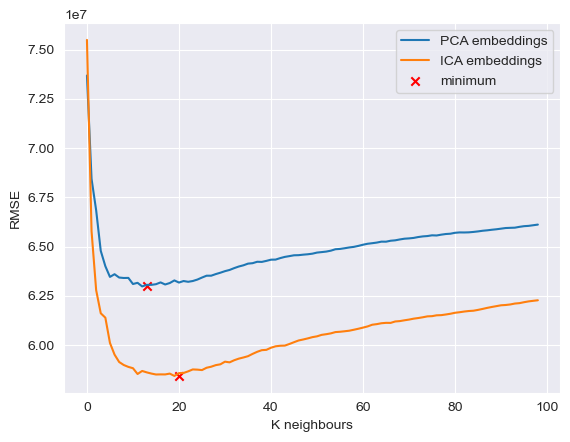

In [47]:
plot_rmse_line(knn_grid_pca, knn_grid_ica, 'PCA embeddings', 'ICA embeddings', 'KNN_model_selection.pdf')

#### Use the best K parameters

In [ ]:
knn_13 = KNeighborsRegressor(n_neighbors=13)
knn_20 = KNeighborsRegressor(n_neighbors=20)